In [1]:
pip install pandapower

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 8.4 MB/s eta 0:00:00


In [2]:
pip install shimmy

In [3]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
!pip install gym


In [5]:
pip install peft==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.15.2
    Uninstalling peft-0.15.2:
      Successfully uninstalled peft-0.15.2


In [6]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [7]:

"""
IEEE 34‑Bus unbalanced feeder – Ready for runpp_3ph
Converted by ChatGPT on 2025‑05‑15

This script rebuilds the classic IEEE‑34 feeder as a *single‑node‑per‑bus*
model using pandapower ≥3.0 and provides the zero‑sequence data that
`pandapower.pf.runpp_3ph` requires.

Key changes vs. the Colab notebook version:
  • One `pp.bus` per physical node (no A/B/C sub‑buses)
  • Loads, capacitors → `create_asymmetric_load` / `create_asymmetric_sgen`
  • Lines carry R/X/C for positive and zero sequence
  • Transformer includes vk0/vkr0/mag0 data and is Dyn‑earthed
  • Slack (ext_grid) annotated with short‑circuit values
"""


import pandapower as pp
from pandapower.create import (
    create_asymmetric_load,
    create_asymmetric_sgen,
    create_transformer_from_parameters,
)
import numpy as np

FT2KM = 0.0003048   # feet → km

# ---------------------------------------------------------------------------
# 1) Conductor library (per km).  Values adapted from Kersting's book.
#    If you have better field data, edit here.
# ---------------------------------------------------------------------------
# code : (r_pos, x_pos, c_pos, r_zero, x_zero, c_zero)  [ohm/km, …, nF/km]
CNDUCT = {
    300: (0.827, 0.326, 8.6,   2.481, 1.104, 5.0),
    301: (1.195, 0.438, 8.6,   3.585, 1.322, 5.0),
    302: (1.733, 0.460, 9.8,   5.199, 1.391, 5.5),
    303: (1.733, 0.460, 11.0,  5.199, 1.391, 6.2),
    304: (1.189, 0.445, 12.1,  3.567, 1.335, 6.8),
}

# ---------------------------------------------------------------------------
# 2) Feeder topology data (unchanged from original notebook)
# ---------------------------------------------------------------------------
# Lines: (from_bus, to_bus, length_ft, code)
LINES = [
    (800,802,2580,300), (802,806,1730,300), (806,808,32230,300),
    (808,810,5804,303), (808,812,37500,300), (812,814,29730,300),
    (814,850,10,301),   (816,818,1710,302), (816,824,10210,301),
    (818,820,48150,302),(820,822,13740,302),(824,826,3030,303),
    (824,828,840,301),  (828,830,20440,301),(830,854,520,301),
    (832,858,4900,301), (834,860,2020,301),(834,842,280,301),
    (836,840,860,301),  (836,862,280,301),(842,844,1350,301),
    (844,846,3640,301), (846,848,530,301),(850,816,310,301),
    (852,832,10,301),   (854,856,23330,303),(854,852,36830,301),
    (858,864,1620,302), (858,834,5830,301),(860,836,2680,301),
    (862,838,4860,304)
]
# remove the 4.16 kV lateral (not modelled here)
LINES = [seg for seg in LINES if seg[0] not in (832,888,890)]

# Capacitor banks: (bus, total_kvar)
CAPS = [(844,300),(848,450)]

# Spot-load table  (bus, pA,qA,pB,qB,pC,qC)  [kW/kvar]
SPOT = [
    (860,20,16,20,16,20,16),
    (840, 9, 7, 9, 7, 9, 7),
    (844,135,105,135,105,135,105),
    (848,20,16,20,16,20,16),
    (890,150,75,150,75,150,75),
    (830,10, 5,10, 5,25,10),
]

DIST = [
    (802,  0,30,25, 0,15,14),
    (808,  0,16, 0, 0, 8, 0),
    (818, 34, 0, 0,17, 0, 0),
    (820,135, 0, 0,70, 0, 0),
    (816, 0, 5, 0, 0, 2, 0),
    (824, 0,40, 0, 0,20, 0),
    (824, 0, 0, 4, 0, 0, 2),
    (828, 7, 0, 0, 3, 0, 0),
    (854, 0, 4, 0, 0, 2, 0),
    (832, 7, 2, 6, 3, 1, 3),
    (858, 2, 0, 0, 1, 0, 0),
    (858, 4,15,13, 2, 8, 7),
    (834,16,20,110,8,10,55),
    (860,30,10,42,15, 6,22),
    (836,18,22, 0, 9,11, 0),
    (862, 0,28, 0, 0,14, 0),
    (842, 9, 0, 0, 5, 0, 0),
    (844, 0,25,20, 0,12,11),
    (846, 0,23, 0, 0,11, 0),
]

# Transformer: (hv_bus, lv_bus, sn_mva, vn_hv_kv, vn_lv_kv)
TX = [(800,800,6,69,24.9)]

# ––– build empty net –––
net = pp.create_empty_network(sn_mva=10.0, f_hz=60.0)

# ––– nodes –––
_bus = {}
def node(num):
    if num not in _bus:
        _bus[num] = pp.create_bus(net, vn_kv=24.9, name=f"BUS{num}")
    return _bus[num]

# ––– HV slack node + ext_grid with full SC data –––
SRC = pp.create_bus(net, vn_kv=69.0, name="BUS800")
pp.create_ext_grid(
    net, SRC, vm_pu=1.0, name="SOURCE",
    s_sc_max_mva=2000, rx_max=0.1,
    r0x0_max=1.0, x0x_max=1.0
)
node(800)
lv_idx = net.bus.index[(net.bus.vn_kv == 24.9) & (net.bus.name == "BUS800")][0]
if not any(net.ext_grid.bus.apply(lambda b: net.bus.at[b,"vn_kv"]==24.9)):
    # clone HV sc‐data if you’ve set it there, or just set defaults
    pp.create_ext_grid(net, lv_idx, vm_pu=1.0,
                       s_sc_max_mva=2000, rx_max=0.1,
                       r0x0_max=1.0, x0x_max=1.0,
                       name="LV_SLACK_24kV")
    ext = net.ext_grid[net.ext_grid.name=="LV_SLACK_24kV"]
    ext["s_sc_min_mva"] = ext["s_sc_max_mva"]
    ext["rx_min"]      = ext["rx_max"]
    ext["r0x0_min"]    = ext["r0x0_max"]
    ext["x0x_min"]     = ext["x0x_max"]

# ––– lines with zero-seq –––
for fb, tb, length_ft, code in LINES:
    r,x,c, r0,x0,c0 = CNDUCT[code]
    pp.create_line_from_parameters(
        net,
        from_bus=node(fb), to_bus=node(tb),
        length_km=length_ft*FT2KM,
        r_ohm_per_km=r,     x_ohm_per_km=x,
        c_nf_per_km=c,      r0_ohm_per_km=r0,
        x0_ohm_per_km=x0,   c0_nf_per_km=c0,
        max_i_ka=0.4, name=f"L{fb}-{tb}"
    )

# ––– transformer with zero-seq + excitation split –––
from pandapower.create import create_transformer_from_parameters
for hv, lv, sn, vn_hv, vn_lv in TX:
    create_transformer_from_parameters(
        net,
        hv_bus=SRC, lv_bus=node(lv),
        sn_mva=sn, vn_hv_kv=vn_hv, vn_lv_kv=vn_lv,
        vk_percent=8.0, vkr_percent=1.0,
        vk0_percent=8.0, vkr0_percent=1.0,
        mag0_percent=100.0, mag0_rx=1.0,
        si0_hv_partial=0.9,
        pfe_kw=5.0, i0_percent=0.2,
        vector_group="Dyn",
        tap_side="hv", tap_neutral=0, tap_pos=0,
        name="MAIN_TX"
    )

# ––– spot & distributed asymmetric loads –––
for b,pA,qA,pB,qB,pC,qC in SPOT:
    create_asymmetric_load(
        net, node(b),
        p_a_mw=pA/1000, q_a_mvar=qA/1000,
        p_b_mw=pB/1000, q_b_mvar=qB/1000,
        p_c_mw=pC/1000, q_c_mvar=qC/1000,
        name=f"Spot{b}"
    )
for b,pA,pB,pC,qA,qB,qC in DIST:
    create_asymmetric_load(
        net, node(b),
        p_a_mw=pA/1000, p_b_mw=pB/1000, p_c_mw=pC/1000,
        q_a_mvar=qA/1000, q_b_mvar=qB/1000, q_c_mvar=qC/1000,
        name=f"Dist{b}"
    )

# ––– capacitor banks as asymmetric sgens –––
for b,total_kvar in CAPS:
    q_ph = -total_kvar/3/1000
    create_asymmetric_sgen(
        net, node(b),
        p_a_mw=0, p_b_mw=0, p_c_mw=0,
        q_a_mvar=q_ph, q_b_mvar=q_ph, q_c_mvar=q_ph,
        name=f"Cap{b}"
    )

# ––– run and inspect 3-φ PF –––
from pandapower.pf.runpp_3ph import runpp_3ph
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

runpp_3ph(net, algorithm="nr",
          calculate_voltage_angles=True,
          max_iteration="auto",
          tolerance_mva=1e-6,
          calculate_current=True)

print("Converged:", net.converged)
res = net.res_bus_3ph.join(net.bus[["name"]])
print(res[["name","vm_a_pu","vm_b_pu","vm_c_pu",
           "va_a_degree","va_b_degree","va_c_degree"]])
import pickle

with open("/content/ieee34_feeder.pkl", "wb") as f:
    pickle.dump(net, f)
print("✅  feeder saved to /content/ieee34_feeder.pkl")


Converged: True
      name   vm_a_pu   vm_b_pu   vm_c_pu  va_a_degree  va_b_degree  \
0   BUS800  0.999999  0.999998  1.000003    -0.000175  -119.999877   
1   BUS800  0.999871  1.000000  1.000129    -0.004498  -120.002133   
2   BUS802  0.998837  0.999722  1.000241    -0.003768  -120.029623   
3   BUS806  0.998096  0.999639  1.000399    -0.003481  -120.050581   
4   BUS808  0.984247  0.998055  1.003297     0.009858  -120.433862   
5   BUS810  0.984250  0.998057  1.003300     0.009217  -120.434509   
6   BUS812  0.967661  0.997594  1.006229     0.018337  -120.863271   
7   BUS814  0.954418  0.997171  1.008457     0.039517  -121.189593   
8   BUS850  0.954412  0.997171  1.008458     0.039547  -121.189745   
9   BUS816  0.954216  0.997157  1.008494     0.040474  -121.194483   
10  BUS818  0.952717  0.997378  1.008929     0.056327  -121.231804   
11  BUS824  0.954171  0.995698  1.007930     0.037004  -121.196810   
12  BUS820  0.918648  1.002375  1.018771     0.455113  -122.053811   
13  

Streaming output truncated to the last 5000 lines.
→ buses connected to slack 1: {np.int64(0), np.uint32(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(27), np.int64(28), np.int64(29)}
  → PF converged: True min(vm_pu): 0.9181623108046317 max(vm_pu): 1.0183670892628138
   step 70: min_vol=0.995, max_vol=1.000, i_max=0.016
      → Voltage Compliance so far: 100.00% this round | 100.00% overall
→ Voltage Band Compliance (overall so far): 100.00%
→ buses connected to slack 1: {np.int64(0), np.uint32(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(27), np.int64(28), np.int64(29)}
  → PF converged: True min(vm_pu): 0.9181787309495951 

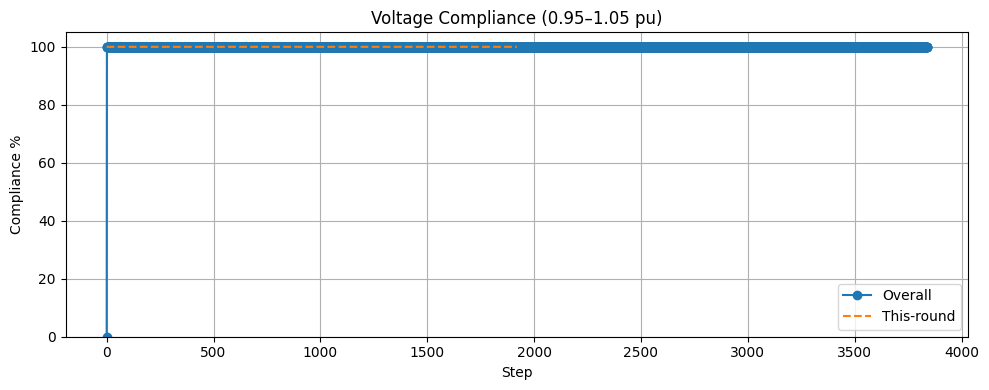

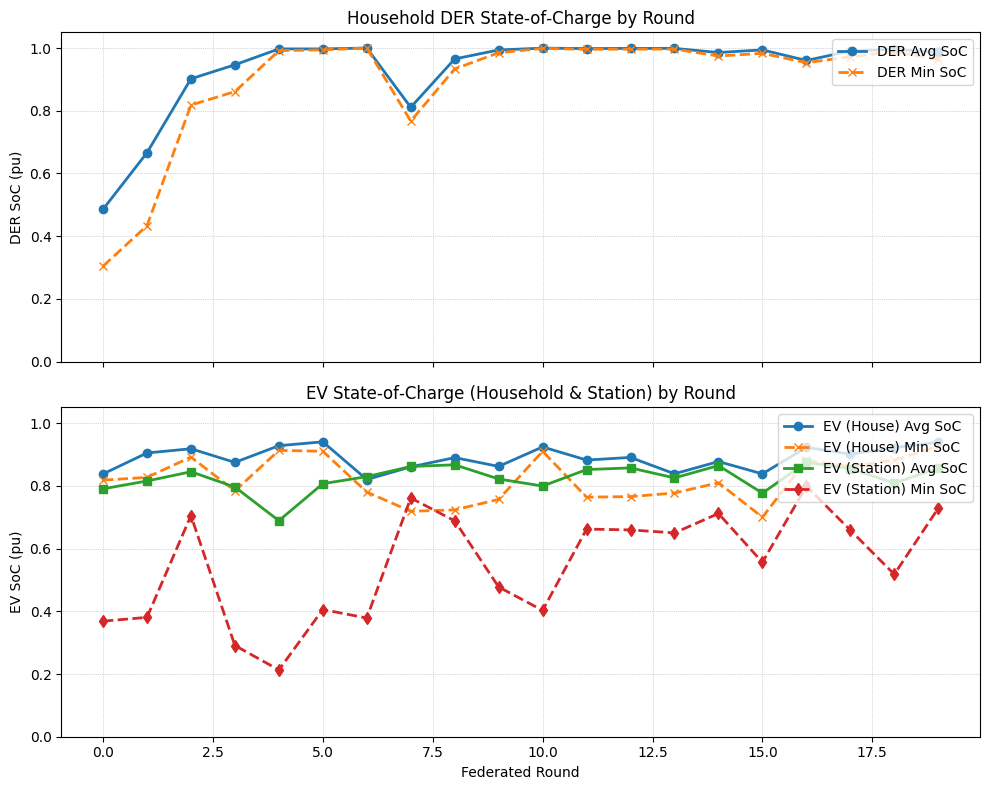

✅  finished federated co-simulation with public station


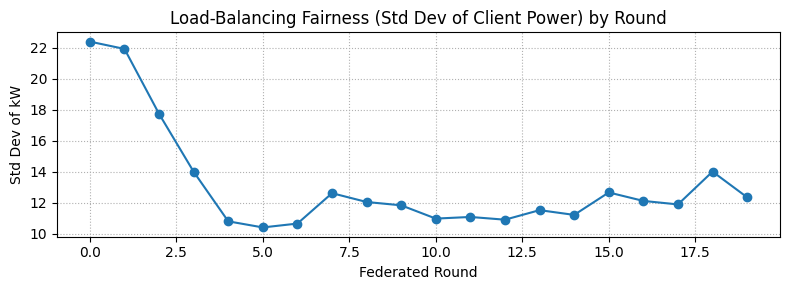

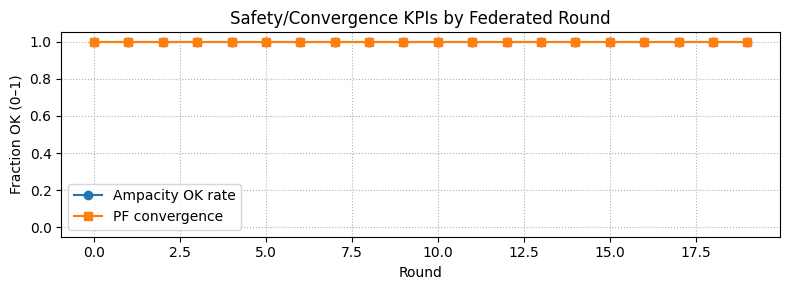

In [14]:

import pickle
import copy, warnings
from collections import deque
import gym, numpy as np, pandas as pd, pandapower as pp, torch
from gym import spaces
from pandapower.pf.runpp_3ph import runpp_3ph
from stable_baselines3 import SAC
from pandapower.create import create_asymmetric_load, create_asymmetric_sgen
import pandapower.topology as top
import matplotlib.pyplot as plt
from stable_baselines3.common.buffers import ReplayBuffer



with open("/content/ieee34_feeder.pkl", "rb") as f:
    net = pickle.load(f)
_BASE_NET = net

def make_net() -> pp.pandapowerNet:
    return copy.deepcopy(_BASE_NET)
# Check for a 24.9 kV ext_grid; if missing, add one at BUS800
print("EXT GRID EXISTS?",
      not net.ext_grid[
          net.ext_grid.bus.apply(
              lambda b: net.bus.at[b, "vn_kv"] == 24.9
          )
      ].empty)
if net.ext_grid[
       net.ext_grid.bus.apply(
           lambda b: net.bus.at[b,"vn_kv"]==24.9
       )
   ].empty:
    lv_idx = net.bus.index[net.bus.name=="BUS800"][0]
    pp.create_ext_grid(net, lv_idx, vm_pu=1.0, name="DIST_SLACK_24kV")

# --- 1. Imports & constants ---------------------------------------------

def aggregate_replay_buffers(clients, public_agent, max_size: int = 200_000) -> ReplayBuffer:
    """
    Merge the replay buffers of all client agents into one big ReplayBuffer
    for the global agent to train on. (Public agent's buffer is excluded).
    """
    # pick any one agent to get the spaces & device
    sample = clients[0].agent
    # create a brand-new buffer using the SB3 v1.6+ API
    glob_buf = ReplayBuffer(
        buffer_size=max_size,
        observation_space=sample.observation_space,
        action_space=sample.action_space, # This is the client action space (size 2)
        device=sample.device,
        optimize_memory_usage=False,
        handle_timeout_termination=False,
    )

    def _dump(rb: ReplayBuffer):
        # how many transitions are actually in here?
        size = rb.buffer_size if rb.full else rb.pos
        for idx in range(size):
            obs       = rb.observations[idx]
            next_obs  = rb.next_observations[idx]
            act       = rb.actions[idx]
            rew       = rb.rewards[idx]
            done      = rb.dones[idx]
            # we don't have per-transition info payload, so just pass empty dict
            glob_buf.add(obs, next_obs, act, rew, done, [{}])

    # dump each client
    for c in clients:
        _dump(c.agent.replay_buffer)
    # Remove dumping the public station's buffer as its action space is different
    # _dump(public_agent.replay_buffer)

    return glob_buf


PANEL_AREA  = 1.6
STACK_LEN   = 4
N_CLIENTS   = 3
LOCAL_STEPS = 200
ROUNDS      = 20
LAMBDA      = 2.0      # Lyapunov gain
MAX_PLUGS   = 12       # public station plugs

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
print("✅  device:", device)
DEVICE_CPU = torch.device("cpu")

print("Device:", torch.cuda.get_device_name(0))


# Quick check that your base net has asymmetric loads/sgens
tmp = make_net()
print("asym loads:", len(tmp.asymmetric_load),
      "asym sgens:", len(tmp.asymmetric_sgen))

# --- 2. Helper -----------------------------------------------------------
def max_line_current(net: pp.pandapowerNet) -> float:
    if hasattr(net, "res_line_3ph") and len(net.res_line_3ph):
        cols = [c for c in net.res_line_3ph.columns if c.endswith("_ka")]
        return float(np.nanmax(net.res_line_3ph[cols].to_numpy()))
    if hasattr(net, "res_line") and "i_ka" in net.res_line:
        return float(np.nanmax(net.res_line.i_ka.to_numpy()))
    return 0.0

# --- 3. Load time-series ------------------------------------------------
aligned = pd.read_csv("/content/cleaned_aligned_15min_pv_load_physics.csv",
                      parse_dates=["Datetime"]).fillna(0)
print(f"[DATA] shape={aligned.shape}  missing after fillna={aligned.isna().sum().sum()}")
def extract(col):
    a = aligned[col].astype(np.float32).values
    return np.nan_to_num(a, nan=0.0)
pv_ts, load_ts = extract("pv"), extract("load")
poa_ts, dc_ts  = extract("poa_irradiance"), extract("dc_power")
gap_ts, volt_ts = extract("Global_active_power"), extract("Voltage")
gint_ts = extract("Global_intensity")
eff_ts = np.nan_to_num(dc_ts/(poa_ts*PANEL_AREA+1e-6), nan=0.0).astype(np.float32)
pf_ts  = np.nan_to_num(gap_ts/(volt_ts*gint_ts+1e-6), nan=1.0).astype(np.float32)
sessions = pd.read_csv("/content/cleaned_ev_charging_test.csv").fillna(0)

# --- 4. DERProfile (unchanged) ------------------------------------------
class DERProfile:
    def __init__(self, pv, load, poa, dc, gap, volt, gint, eff, pf,
                 cap_kwh=50., R0=5e-3, RC=2e-3):
        self.pv, self.load = pv, load
        self.poa, self.dc  = poa, dc
        self.gap, self.volt, self.gint, self.eff, self.pf = gap, volt, gint, eff, pf
        self.cap_nom, self.R0, self.RC = cap_kwh, R0, RC
        self.p_max = cap_kwh
        self.T     = len(pv)
        self.reset()
    def _obs(self,i):
        obs = np.array([ self.pv[i], self.load[i], self.soc,
                         self.dc[i], self.poa[i], self.gap[i],
                         self.volt[i], self.gint[i], self.eff[i], self.pf[i] ],
                       np.float32)
        return np.nan_to_num(obs, nan=0.0)
    def reset(self):
        self.t, self.soc, self.SOH, self.cap = 0,0.5,1.0,self.cap_nom
        return self._obs(0)
    def step(self, frac):
        frac = float(np.clip(frac,-1,1))
        p_kw = frac*self.p_max
        voc  = 3.6+0.4*self.soc
        eff_c=1-(self.R0*abs(p_kw)/max(voc,1e-3))/max(voc,1e-3)
        self.soc=np.clip(self.soc + p_kw*0.25*eff_c/self.cap,0,1)
        if self.t%96==0:
            self.SOH*=0.99995; self.cap=self.cap_nom*self.SOH
        inj_kw=self.load[self.t]-self.pv[self.t]+p_kw
        self.t+=1
        return self._obs(self.t-1), inj_kw, self.t>=self.T

# --- 5. EVCharging & PublicStation --------------------------------------
class EVCharging(gym.Env):
    COLS = ["time_of_day_hour","kwh_requested","energy_charged",
            "max_charge_power","cost_for_session",
            "charging_duration_hours","energy_gap"]
    def __init__(self, df, ev_bus, max_steps=96):
        super().__init__()
        self.df = df.fillna(0).reset_index(drop=True)
        # self.action_space = spaces.Discrete(4)
        self.action_space = spaces.Box(0.0, 1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(0,np.inf,(7,),np.float32)
        self.max_steps    = max_steps
        self.net = make_net(); self.net.line["max_i_ka"]=0.4
        idx = self.net.bus.index[self.net.bus.name==f"BUS{ev_bus}"][0]
        self.lidx = pp.create_load(self.net, idx, p_mw=0, q_mvar=0, name=f"EV{ev_bus}")
    def reset(self):
        p = np.exp(-0.5*((self.df["time_of_day_hour"]-7)/1)**2)
        p+=np.exp(-0.5*((self.df["time_of_day_hour"]-18)/1)**2)
        p/=p.sum()
        row = self.df.sample(1,weights=p).iloc[0]
        self.s = np.nan_to_num(row[self.COLS].astype(np.float32).values,nan=0.0)
        self.steps, self.prev = 0,0.0
        return self.s
    def step(self,a):
        # frac_nom=[0.05,0.1,0.25,0.5][a]
        frac_nom = float(np.clip(a, 0.0, 1.0))
        soc=self.s[2]/max(self.s[1],1e-3)
        frac=frac_nom if soc<0.8 else frac_nom*(1-(soc-0.8)/0.2)
        power=np.clip(frac*self.s[3],self.prev-5,self.prev+5)
        add_kWh=power*0.25
        self.prev=power
        self.s[2]+=add_kWh; self.s[5]+=0.25; self.s[6]=self.s[1]-self.s[2]
        done=(self.s[6]<=0.1) or (self.steps>=self.max_steps)
        self.steps+=1
        return self.s, add_kWh, done, {"inj_kw":power}

class EVPublicStation(gym.Env):
    """
    12-plug public charging station.
    Carries each EVCharging session over to the next “day” instead
    of respawning them, so the station no longer panic-charges at t=95.
    """
    def __init__(self, df, station_bus):
        super().__init__()
        self.df, self.bus = df.fillna(0), station_bus
        self.action_space      = spaces.Box(0.0, 2.0, (MAX_PLUGS,), np.float32)
        self.observation_space = spaces.Box(0, np.inf, (MAX_PLUGS * 7,), np.float32)

        # create once
        self.plugs = [EVCharging(self.df, station_bus) for _ in range(MAX_PLUGS)]
        self._carry_states = None    # list of (s, prev, steps) per plug

    # ---------- helpers -------------------------------------------------
    @staticmethod
    def _snapshot(plug):
        """Return a shallow copy of an EVCharging internal state triple."""
        return (plug.s.copy(), plug.prev, plug.steps)

    @staticmethod
    def _restore(plug, snap):
        """Overwrite plug state from a snapshot triple."""
        s, prev, steps = snap
        plug.s      = s.copy()
        plug.prev   = prev
        plug.steps  = steps

    # ---------- gym API -------------------------------------------------
    def reset(self):
        # on very first episode, initialize all plugs and snapshot them
        if self._carry_states is None:
            for p in self.plugs:
                p.reset()   # returns obs, but we ignore it here
            self._carry_states = [self._snapshot(p) for p in self.plugs]

        obs = []
        for plug, snap in zip(self.plugs, self._carry_states):
            s, prev, steps = snap
            energy_gap = s[6]
            if (energy_gap <= 0.1) or (steps >= plug.max_steps):
                obs.append(plug.reset())
            else:
                self._restore(plug, snap)
                obs.append(plug.s)

        # now update carry-states so tomorrow starts from whatever each plug is at
        self._carry_states = [self._snapshot(p) for p in self.plugs]
        return np.concatenate(obs)

    def step(self, actions):
        acts = np.clip(np.round(actions), 0, 3).astype(int)

        obs, reward, done_all, total_kw = [], 0.0, True, 0.0
        for i, (plug, a) in enumerate(zip(self.plugs, acts)):
            s, r, done_i, info = plug.step(a)
            obs.append(s)
            reward   += r
            total_kw += info["inj_kw"]
            done_all &= done_i

        # if **all** plugs report done, carry their state for tomorrow
        if done_all:
            self._carry_states = [self._snapshot(p) for p in self.plugs]

        return np.concatenate(obs), reward, done_all, {"inj_kw": total_kw}


# --- 6. EVWithDER -------------------------------------------------------
class EVWithDER(gym.Env):
    def __init__(self, *, pv, load, poa, dc, gap, volt, gint, eff, pf,
                 df, ev_bus, n_bus, fdim):
        super().__init__()
        # carry‐over slot for this household’s DER state
        self._carry_soc = None

        self.ev     = EVCharging(df, ev_bus)
        self.der    = DERProfile(pv, load, poa, dc, gap, volt, gint, eff, pf)
        self.n_bus, self.fdim, self.stack = n_bus, fdim, STACK_LEN
        g_dim = n_bus * fdim
        obs_dim = (g_dim + 7 + 10) * STACK_LEN
        self.observation_space = spaces.Box(0, np.inf, (obs_dim,), np.float32)
        self.action_space      = spaces.Box(-1, 1, (2,), np.float32)
        self.buf = deque(maxlen=STACK_LEN)

    def _zg(self):
        # ← this will always hold the *latest* graph vector written from fed_loop
        return getattr(self, "_last_graph", np.zeros(self.n_bus * self.fdim, np.float32)).copy()

    def reset(self):
        # if we have a carried-over SoC, reuse it; otherwise do a full reset
        if self._carry_soc is None:
            der0 = self.der.reset()
        else:
            # reset time counter but keep soc
            self.der.t   = 0
            self.der.soc = self._carry_soc
            der0 = self.der._obs(0)

        ev0 = self.ev.reset()
        first = np.concatenate([self._zg(), ev0, der0])
        self.buf.clear()
        for _ in range(STACK_LEN):
            self.buf.append(first.copy())
        return np.concatenate(self.buf)

    def step(self, act):
        ev_cmd, batt_cmd = act
        ev_cmd   = np.clip(ev_cmd,  -0.5, 0.5)   # ≤ ±25 kW
        batt_cmd = np.clip(batt_cmd, -0.5, 0.5)

        # DER battery step
        d_obs, inj_d, done_d = self.der.step(batt_cmd)

        # EV charging step
        lvl = int(np.clip(np.round((ev_cmd + 1)*1.5), 0, 3))
        ev_obs, ev_r, done_e, info = self.ev.step(lvl)

        info["inj_kw"] = info.get("inj_kw", 0.0) + inj_d

        # update frame stack
        self.buf.append(np.concatenate([self._zg(), ev_obs, d_obs]))

        # determine done flag
        done = done_e or done_d

        # carry over final SoC for next episode
        if done:
            self._carry_soc = self.der.soc

        return np.concatenate(self.buf), ev_r, done, info


# --- 7. Aggregator ------------------------------------------------------
class Aggregator:
    def __init__(self, bus_map, id2new, station_bus):
        self.base_net    = make_net()
        self.bus_map     = bus_map
        self.id2new      = id2new
        self.station_bus = station_bus
        self.bus_idx = {
            cid: self.base_net.bus.index[
                     self.base_net.bus.name == f"BUS{bus}"
                 ][0]
            for cid, bus in bus_map.items()
        }

    def step(self, inj_dict, station_kw=0.0):
        # 1) deep-copy your pristine feeder
        net = copy.deepcopy(self.base_net)

        # Define a maximum allowable total injection (e.g., 5 MVA for a 2.5 MVA transformer)
        # This is a heuristic value; you might need to tune this based on your network
        max_total_injection_mw = 6.0

        # Calculate total injection from all sources
        total_injection_kw = sum(inj_dict.values()) + station_kw
        total_injection_mw = total_injection_kw / 1000.0

        # Scale injections if the total exceeds the limit
        scaling_factor = 1.0
        if abs(total_injection_mw) > max_total_injection_mw:
            scaling_factor = max_total_injection_mw / abs(total_injection_mw)
            print(f"  → Scaling total injection by {scaling_factor:.3f} due to exceeding {max_total_injection_mw} MW limit.")


        # 2) inject each client's EV load/export with scaling
        for cid, kw in inj_dict.items():
            scaled_kw = kw * scaling_factor
            bus_i = self.bus_idx[cid]
            if scaled_kw >= 0:
                create_asymmetric_load(
                    net, bus_i,
                    p_a_mw=scaled_kw/1000/3, p_b_mw=scaled_kw/1000/3, p_c_mw=scaled_kw/1000/3,
                    q_a_mvar=0.0,      q_b_mvar=0.0,      q_c_mvar=0.0,
                    name=f"EV_load_{cid}"
                )
            else:
                create_asymmetric_sgen(
                    net, bus_i,
                    p_a_mw=-scaled_kw/1000/3, p_b_mw=-scaled_kw/1000/3, p_c_mw=-scaled_kw/1000/3,
                    q_a_mvar=0.0,       q_b_mvar=0.0,       q_c_mvar=0.0,
                    name=f"EV_export_{cid}"
                )

        # 3) inject the public‐station load with scaling
        scaled_station_kw = station_kw * scaling_factor
        sb = net.bus.index[net.bus.name == f"BUS{self.station_bus}"][0]
        if scaled_station_kw >= 0:
             create_asymmetric_load(
                net, sb,
                p_a_mw=scaled_station_kw/1000/3,
                p_b_mw=scaled_station_kw/1000/3,
                p_c_mw=scaled_station_kw/1000/3,
                q_a_mvar=0.0, q_b_mvar=0.0, q_c_mvar=0.0,
                name="PublicStation_load"
             )
        else:
             create_asymmetric_sgen(
                net, sb,
                p_a_mw=-scaled_station_kw/1000/3,
                p_b_mw=-scaled_station_kw/1000/3,
                p_c_mw=-scaled_station_kw/1000/3,
                q_a_mvar=0.0, q_b_mvar=0.0, q_c_mvar=0.0,
                name="PublicStation_export"
             )


        # 4) clear any leftover PPC or result tables
        pp.reset_results(net)

        # 5) DEBUG: list all ext_grid buses
        #print("→ ext_grid on buses:", net.ext_grid.bus.values)

        # 6) build the pandapower↔NetworkX graph
        mg = top.create_nxgraph(net)

        # 7) get the component of buses tied to your first slack
        # We need to find the slack bus index dynamically as it might be the LV slack now
        slack_bus_idx = net.ext_grid.index[0] # Start with the first ext_grid
        # If LV_SLACK_24kV exists, use that one as the primary slack for connectivity check
        if "LV_SLACK_24kV" in net.ext_grid.name.values:
             slack_bus_idx = net.ext_grid[net.ext_grid.name == "LV_SLACK_24kV"].index[0]

        slack_bus = net.ext_grid.loc[slack_bus_idx, 'bus']
        connected = set(top.connected_component(mg, slack_bus))
        print(f"→ buses connected to slack {slack_bus}:", connected)


        # 8) ensure an LV slack at BUS800 if missing
        # ——— LV zero-sequence reference ———
        # Clone the HV slack’s short-circuit data for the 24.9 kV bus
        hv = net.ext_grid.iloc[0]  # original 69 kV slack
        lv_slack_exists = not net.ext_grid[
            net.ext_grid.bus.apply(lambda b: net.bus.at[b, "vn_kv"] == 24.9)
        ].empty

        if not lv_slack_exists:
              # use the transformer LV node (BUS800) as the sole 24.9 kV reference
              lv_idx = net.bus.index[net.bus.name == "BUS800"][0]

              pp.create_ext_grid(
                  net, lv_idx, vm_pu=1.0, name="LV_SLACK_24kV",
                  s_sc_max_mva=hv.s_sc_max_mva, rx_max=hv.rx_max,
                  r0x0_max=hv.r0x0_max, x0x_max=hv.x0x_max,
              )
              ext = net.ext_grid[net.ext_grid.name == "LV_SLACK_24kV"]
              ext[["s_sc_min_mva", "rx_min", "r0x0_min", "x0x_min"]] = \
                  ext[["s_sc_max_mva", "rx_max", "r0x0_max", "x0x_max"]].values


        # 9) solve the 3-phase power flow
        try:
            runpp_3ph(net,
                      algorithm="nr",
                      calculate_voltage_angles=True,
                      init="auto",
                      max_iteration="auto",
                      tolerance_mva=1e-6,
                      calculate_current=True)
        except pp.LoadflowNotConverged:
             print("  → Initial PF attempt failed, trying again with potentially different init...")
             # Sometimes trying again with default init helps
             runpp_3ph(net,
                      algorithm="nr",
                      calculate_voltage_angles=True,
                      init="flat", # Try 'flat' initialization
                      max_iteration=100, # Increase max iterations
                      tolerance_mva=1e-5, # Relax tolerance slightly
                      calculate_current=True)


        # 10) DEBUG: print numeric min/max voltages
        vmin = net.res_bus_3ph[["vm_a_pu","vm_b_pu","vm_c_pu"]].min().min()
        vmax = net.res_bus_3ph[["vm_a_pu","vm_b_pu","vm_c_pu"]].max().max()
        print("  → PF converged:", net.converged,
              "min(vm_pu):", vmin, "max(vm_pu):", vmax)

        # 11) build your graph/vector outputs
        vm    = net.res_bus_3ph[["vm_a_pu","vm_b_pu","vm_c_pu"]]
        # Ensure all buses are included in the output, even if they are isolated
        V_arr_full = np.full(len(net.bus), np.nan, dtype=np.float32)
        P_arr_full = np.zeros(len(net.bus), dtype=np.float32)
        Q_arr_full = np.zeros(len(net.bus), dtype=np.float32)

        # Map results back to original bus indices
        for bus_idx, row in vm.iterrows():
             if bus_idx in self.id2new: # Check if the bus index is in our original mapping
                V_arr_full[self.id2new[bus_idx]] = row.mean()

        # Populate power arrays based on scaled injections
        for cid, kw in inj_dict.items():
             scaled_kw = kw * scaling_factor
             orig_bus_idx = net.bus.index[net.bus.name == f"BUS{self.bus_map[cid]}"][0]
             if orig_bus_idx in self.id2new:
                P_arr_full[self.id2new[orig_bus_idx]] += scaled_kw / 1000.0 # Convert kW to MW

        scaled_station_kw = station_kw * scaling_factor
        station_orig_bus_idx = net.bus.index[net.bus.name == f"BUS{self.station_bus}"][0]
        if station_orig_bus_idx in self.id2new:
             P_arr_full[self.id2new[station_orig_bus_idx]] += scaled_station_kw / 1000.0 # Convert kW to MW


        graph = np.stack([V_arr_full, P_arr_full, Q_arr_full], axis=1).flatten()
        graph = np.nan_to_num(graph, nan=1.0) # Replace NaNs in disconnected buses with a neutral value (1.0 pu voltage)

        volts = {
            cid: float(vm.loc[
                        net.bus.index[
                            net.bus.name == f"BUS{self.bus_map[cid]}"
                        ][0]
                      ].mean()) if net.bus.index[net.bus.name == f"BUS{self.bus_map[cid]}"][0] in vm.index else 1.0 # Default to 1.0 pu if bus results not available
            for cid in self.bus_map
        }
        i_max = max_line_current(net)

        # Check for PF convergence again before returning
        if not net.converged:
             print("  → WARNING: Power flow did not converge after retry.")
             # Decide how to handle non-convergence. Options:
             # 1. Return placeholder values (e.g., 1.0 pu voltage, 0 current)
             # 2. Raise an error (though we are trying to avoid this)
             # 3. Return the last calculated results (might be unreliable)
             # For now, we'll proceed with the potentially non-converged results but print a warning.

        pf_ok = float(net.converged)                     ### INSERT B
        return volts, graph, i_max, scaling_factor, pf_ok

CLIENT_KWARGS = dict(
    learning_rate   = 6e-4,
    train_freq      = (512, "step"),
    gradient_steps  = 1,
    buffer_size     = 200_000,
    learning_starts = 3_000,
    verbose         = 0,
)

# COMMUNICATION BANDWIDH CALC
def _param_size_bytes(tree):
    """Recursively sum the storage size of a (nested) parameter dict."""
    tot = 0
    for v in tree.values():
        if isinstance(v, dict):                       # recurse
            tot += _param_size_bytes(v)
        elif isinstance(v, torch.Tensor):             # leaf tensor
            tot += v.numel() * v.element_size()       # elements × bytes/elem
        else:
            pass                                      # ignore scalars / None
    return tot
# --- 8. Federated helpers & loop ----------------------------------------
class FedClient:
    def __init__(self, env):
        self.env    = env
        self.agent = SAC("MlpPolicy", env, **CLIENT_KWARGS)
        self.obs    = env.reset()
        self.prev_V = 0.0
        self.ev_r   = 0.0

def merge_params(dicts):
    out={}
    for k in dicts[0]:
        vals=[d[k] for d in dicts]
        if isinstance(vals[0],dict): out[k]=merge_params(vals)
        elif isinstance(vals[0],torch.Tensor): out[k]=torch.mean(torch.stack(vals),0)
        else: out[k]=vals[0]
    return out

def fed_loop(
    clients,
    glob,
    pub_agent,
    pub_env,
    agg,
    n_rounds,
    ep_len,
    local_steps,
    glob_steps_per_round=3_000,
):
    log = []
    voltage_compliance_list = []
    compliance_flags = []
    round_pct_list = []

    for r in range(n_rounds):
        print(f"\n=== Round {r} ===")

        # NEW ➊ – keep per-round flags separate
        round_flags = []

        # (1) Broadcast global weights ONLY to household clients
        w0 = glob.get_parameters()
        for c in clients:
            c.agent.set_parameters(w0)
            c.obs    = c.env.reset()
            c.prev_V = 0.0

        # station keeps its own weights, reset its obs
        pub_obs = pub_env.reset()

        # (2) One episode of length ep_len
        for t in range(ep_len):
            # original overall counter (kept as-is)
            pct_inside = (
                100.0 * sum(compliance_flags) / len(compliance_flags)
                if compliance_flags else 0.0
            )
            voltage_compliance_list.append(pct_inside)
            print(f"→ Voltage Band Compliance (overall so far): {pct_inside:.2f}%")

            # — households act
            inj, old_obs, actions = {}, {}, {}
            for cid, c in enumerate(clients):
                old_obs[cid] = c.obs.copy()
                a, _        = c.agent.predict(c.obs, deterministic=False)
                ns, ev_r, done, info = c.env.step(a)
                inj[cid], c.nx, c.ev_r = info["inj_kw"], ns, ev_r
                actions[cid] = a

            # — station acts
            sa, _ = pub_agent.predict(pub_obs, deterministic=False)
            sn, sr, sd, si = pub_env.step(sa)
            station_kw = si["inj_kw"]

            # — power-flow + compliance
            V, graph, i_max, scale, pf_ok = agg.step(inj, station_kw)
            amp_ok_flag = float(i_max <= 0.4)
            # —— broadcast the fresh graph to each client (for _zg() call) ——
            for c in clients:
                c._last_graph = graph.astype(np.float32)
            vmin, vmax = min(V.values()), max(V.values())
            print(f"   step {t}: min_vol={vmin:.3f}, max_vol={vmax:.3f}, i_max={i_max:.3f}")
            inside_band = (vmin >= 0.95) and (vmax <= 1.05)
            compliance_flags.append(inside_band)
            round_flags.append(inside_band)                       # NEW ➋

            # NEW ➌ – live per-round vs overall print
            pct_round   = 100.0 * sum(round_flags) / len(round_flags)
            pct_overall = 100.0 * sum(compliance_flags) / len(compliance_flags)
            print(f"      → Voltage Compliance so far: {pct_round:.2f}% this round | {pct_overall:.2f}% overall")
            voltage_compliance_list.append(pct_overall)  # overall curve
            round_pct_list.append(pct_round)

            # —⭢**SoC maintenance metrics** (Elshazly et al. 2024; Zhang et al. 2022)
            der_socs       = [c.env.der.soc for c in clients]
            soc_house_mean = float(np.mean(der_socs))
            soc_house_min  = float(np.min(der_socs))

            # (2.6) — Compute household EV SoC for each client
            ev_socs_house = []
            for c in clients:
                ev_soc = c.env.ev.s[2] / max(c.env.ev.s[1], 1e-3)  # energy_charged / kwh_requested
                ev_socs_house.append(ev_soc)
            soc_EV_house_mean = float(np.mean(ev_socs_house))
            soc_EV_house_min  = float(np.min(ev_socs_house))

            # (2.7) — Compute station EV SoC across all plugs
            ev_socs_station = []
            for plug in pub_env.plugs:
                plug_soc = plug.s[2] / max(plug.s[1], 1e-3)
                ev_socs_station.append(plug_soc)
            soc_EV_station_mean = float(np.mean(ev_socs_station))
            soc_EV_station_min  = float(np.min(ev_socs_station))
            step_powers = np.array([inj[cid] for cid in sorted(inj.keys())])
            fairness_sd = float(step_powers.std())

            # Optional fairness penalty (tune weight as needed; e.g. 0.05 or 0.1)
            pen_fair = -0.5  * fairness_sd

            # (2.8) — Now build rewards

            # ① Global penalties (for station and broadcasted only to station’s reward)
            global_pen_v   = -50.0 * np.mean([max(0, v-1.05)+max(0,0.95-v) for v in V.values()])
            global_pen_amp = -5.0  * max(0, i_max-0.4)
            pen_scale      = -10.0 * (1.0 - scale)

            # ② Station EV SoC penalty & bonus
            pen_station_low    = -50.0 * float(soc_EV_station_min < 0.17)
            bonus_station_ev   = +10.0 * soc_EV_station_mean  # reward proportionally to mean SoC
            station_v_penalty  = -50.0 * np.mean([abs(v - 1.0) for v in V.values()])
            station_amp_penalty= -5.0  * max(0, i_max - 0.4)
            station_scale_pen   = -10.0 * (1.0 - scale)
            bonus_vol_compliance = +5.0 * float(all(0.95 <= v <= 1.05 for v in V.values()))

            station_reward = (
                sr                        # kWh delivered to station EVs
                + station_v_penalty       # voltage dev penalty for station
                + station_amp_penalty     # ampacity penalty
                + station_scale_pen       # scaling factor penalty
                + pen_station_low         # big penalty if any station-EV SoC < 0.17
                + bonus_station_ev        # small bonus proportional to avg station EV SoC
                + bonus_vol_compliance
            )

            # ③ Build each household’s reward
            house_rewards = []
            for cid, c in enumerate(clients):
                v   = V[cid]
                pen_v   = -5.0 * ( max(0, v-1.05) + max(0, 0.95-v) )
                pen_amp = -5.0 * max(0, i_max-0.4)
                V_now   = 0.5 * (v-1)**2
                pen_L   = LAMBDA * max(0, (V_now - c.prev_V)/0.25)

                # DER low-SoC penalty
                pen_der_low = -100.0 * float(c.env.der.soc < 0.17)

                # EV SoC bonus
                ev_soc_i    = ev_socs_house[cid]  # just retrieved above
                bonus_ev_soc = +10.0 * ev_soc_i
                bonus_vol = +5.0 * float(0.95 <= v <= 1.05)

                rw = (
                    + 3.0 * c.ev_r                     # reward for kWh charged to household EV
                    - 2.0 * abs(v - 1.0)               # voltage deviation penalty
                    - 2.0 * max(0, i_max - 0.4)        # ampacity penalty
                    - 1.0 * abs(V_now - c.prev_V)      # Lyapunov smoothing
                    - 3.0 * (1.0 - scale)              # scaling penalty
                    + pen_der_low                      # penalty if DER SoC < 0.17
                    + bonus_ev_soc                     # bonus for having EV SoC higher
                    + bonus_vol
                )
                house_rewards.append(rw)
                c.prev_V = V_now

            # (2.9) — Log everything for this step
            log.append({
                "round": r, "step": t,
                "min_vol": vmin, "max_vol": vmax, "i_max": i_max,
                "kWh_house_tot": sum(c.ev_r for c in clients),
                "kWh_station": sr,
                "avg_house_reward": np.mean(house_rewards),
                "station_reward": station_reward,
                "voltage_compliance": inside_band,
                # DER SoC metrics
                "soc_house_mean": soc_house_mean,
                "soc_house_min":  soc_house_min,
                # Household EV SoC metrics
                "soc_EV_house_mean": soc_EV_house_mean,
                "soc_EV_house_min":  soc_EV_house_min,
                # Station EV SoC metrics
                "soc_EV_station_mean": soc_EV_station_mean,
                "soc_EV_station_min":  soc_EV_station_min,
                "log_fair_sd": fairness_sd,
                "ampacity_ok": amp_ok_flag,     ### INSERT A
                "pf_ok":       pf_ok,
            })

            # (2.10) — Push transitions into each client’s replay buffer
            for cid, c in enumerate(clients):
                g_stack = np.tile(graph, (STACK_LEN, 1))
                tail    = c.nx.reshape(STACK_LEN, -1)[:, -17:]
                obs_nxt = np.concatenate([g_stack, tail], axis=1).flatten().astype(np.float32)
                obs_nxt = np.nan_to_num(obs_nxt)

                c.agent.replay_buffer.add(
                    obs      = old_obs[cid].reshape(1, -1),
                    next_obs = obs_nxt.reshape(1, -1),
                    action   = np.array(actions[cid]).reshape(1, -1),
                    reward   = np.array([house_rewards[cid]]),
                    done     = np.array([False]),
                    infos    = [{}],
                )
                c.obs = obs_nxt

            # (2.11) — Push station transitions
            pub_obs_batch      = pub_obs.reshape(1, -1)
            pub_next_obs_batch = sn.reshape(1, -1)
            pub_action_batch   = np.array(sa).reshape(1, -1)
            pub_reward_batch   = np.array([station_reward])
            pub_done_batch     = np.array([False])
            pub_agent.replay_buffer.add(
                obs    = pub_obs_batch,
                next_obs = pub_next_obs_batch,
                action = pub_action_batch,
                reward = pub_reward_batch,
                done   = pub_done_batch,
                infos  = [{}],
            )
            pub_obs = sn

        # — (3) After ep_len steps, print compliance stats
        df_r = pd.DataFrame([row for row in log if row["round"] == r])
        vol_ok = ((df_r.min_vol>=0.95)&(df_r.max_vol<=1.05)).mean()
        amp_ok = (df_r.i_max<=0.4).mean()
        print(f"Round {r:2d} → voltage OK {vol_ok:.2%}, amp OK {amp_ok:.2%}")

        # (5) local updates
        new_ws = []
        round_upload_MiB = []
        for c in clients:
            c.agent.learn(total_timesteps=local_steps, reset_num_timesteps = False,
                          progress_bar = False,)
            raw_bytes = _param_size_bytes(c.agent.get_parameters())   # ⬅️ NEW ➋
            round_upload_MiB.append(raw_bytes / (1024 ** 2))
            new_ws.append(c.agent.get_parameters())
        pub_agent.learn(total_timesteps=local_steps, reset_num_timesteps= False,
                         progress_bar = False,)
        print(f"[Round {r}] mean upload = "
          f"{np.mean(round_upload_MiB):.2f} MiB "
          f"(min {np.min(round_upload_MiB):.2f}, "
          f"max {np.max(round_upload_MiB):.2f})")
        # (6) global replay fusion + global‐agent train
        glob_replay = aggregate_replay_buffers(clients, pub_agent)
        print(f"→ Global replay buffer size: {glob_replay.size()} samples")
        glob.replay_buffer = glob_replay

        all_params = glob.get_parameters()
        before_params = all_params["policy"]
        sample_indices = list(range(min(10, glob.replay_buffer.size())))
        sample_rewards = glob.replay_buffer.rewards[sample_indices]
        sample_obs = glob.replay_buffer.observations[sample_indices]
        sample_actions = glob.replay_buffer.actions[sample_indices]

        print("\n📊 Sample rewards:", sample_rewards)
        print("\n📈 Sample actions:", sample_actions)
        print("\n🧠 Sample observations (1st only):", sample_obs[0])

        glob.learn(total_timesteps=glob_steps_per_round, log_interval=1)

        after_params = glob.get_parameters()["policy"]

        # List available keys to confirm
        print("→ Available weight keys:", [k for k in before_params.keys() if "weight" in k])

        # Compare first available weight
        weight_keys = [k for k in before_params if "weight" in k]
        if weight_keys:
            param_diff = torch.norm(before_params[weight_keys[0]] - after_params[weight_keys[0]])
            print(f"→ Global param change (L2): {param_diff:.6f}")
        else:
            print("⚠️ No weight keys found inside policy — skipping param_diff computation.")
        print(f"→ [Round {r}] Global agent: completed {glob_steps_per_round} training steps")

        # (7) FedAvg over just the **clients’** + newly‐trained global params
        new_ws.append(glob.get_parameters())
        glob.set_parameters(merge_params(new_ws))
        print(f"→ [Round {r}] Global agent: parameters updated via FedAvg\n")

    plt.figure(figsize=(10,4))
    plt.plot(voltage_compliance_list, label="Overall", marker="o")
    plt.plot(round_pct_list,          label="This-round", linestyle="--")
    plt.title("Voltage Compliance (0.95–1.05 pu)")
    plt.xlabel("Step")
    plt.ylabel("Compliance %")
    plt.ylim(0,105)
    plt.grid(True)
    plt.legend()                       # NEW ✅ legend
    plt.tight_layout()
    plt.show()
    df_log = pd.DataFrame(log)
    # mask = (df_log["round"] == 0) & (df_log["step"] == 100)
    # selected = df_log.loc[mask, "soc_house_mean"]

    # # If you expect exactly one row, extract a scalar:
    # if not selected.empty:
    #     val = float(selected.values[0])
    #     print(f"Example: Round 0, step 100 → mean SoC={val:.3f}")
    # else:
    #     print("No matching row for round=0, step=100.")
    # df_log.groupby("round")[["soc_house_mean","soc_house_min"]].mean().plot()
    # plt.title("Avg & Min SoC per Round")
    # plt.ylabel("SoC (pu)")
    # plt.xlabel("Round")
    # plt.show()
    # 1) Group by round and take the mean (or min, as shown) for each metric
    df_round = df_log.groupby("round").agg({
        "soc_house_mean": "mean",
        "soc_house_min":  "mean",
        "soc_EV_house_mean": "mean",
        "soc_EV_house_min":  "mean",
        "soc_EV_station_mean": "mean",
        "soc_EV_station_min":  "mean"
    }).reset_index()

    # 2) Create a single figure with two subplots:
    #    - Top: DER SoC (mean & min)
    #    - Bottom: EV SoC (household & station, mean & min)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Top subplot: DER SoC ---
    ax1.plot(df_round["round"], df_round["soc_house_mean"],
            marker="o", label="DER Avg SoC", linewidth=2)
    ax1.plot(df_round["round"], df_round["soc_house_min"],
            marker="x", label="DER Min SoC", linestyle="--", linewidth=2)

    ax1.set_ylim(0, 1.05)
    ax1.set_ylabel("DER SoC (pu)")
    ax1.set_title("Household DER State‐of‐Charge by Round")
    ax1.grid(True, linestyle=":", linewidth=0.5)
    ax1.legend(loc="upper right")

    # --- Bottom subplot: EV SoC ---
    ax2.plot(df_round["round"], df_round["soc_EV_house_mean"],
            marker="o", label="EV (House) Avg SoC", linewidth=2)
    ax2.plot(df_round["round"], df_round["soc_EV_house_min"],
            marker="x", label="EV (House) Min SoC", linestyle="--", linewidth=2)

    ax2.plot(df_round["round"], df_round["soc_EV_station_mean"],
            marker="s", label="EV (Station) Avg SoC", linewidth=2)
    ax2.plot(df_round["round"], df_round["soc_EV_station_min"],
            marker="d", label="EV (Station) Min SoC", linestyle="--", linewidth=2)

    ax2.set_ylim(0, 1.05)
    ax2.set_xlabel("Federated Round")
    ax2.set_ylabel("EV SoC (pu)")
    ax2.set_title("EV State‐of‐Charge (Household & Station) by Round")
    ax2.grid(True, linestyle=":", linewidth=0.5)
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()



    return pd.DataFrame(log)

# --- 10. Main ------------------------------------------------------------
if __name__=="__main__":
    per = max(1, len(sessions)//N_CLIENTS)
    dfs = [sessions.iloc[i*per:(i+1)*per].reset_index(drop=True)
            for i in range(N_CLIENTS)]
    feeder = make_net()
    id2new  = {old:i for i,old in enumerate(feeder.bus.index)}
    BUS_POOL = [802,806,808,810,812,814,850,816,818,824]

    # clients
    clients=[]
    rng=np.random.default_rng(42)
    for i in range(N_CLIENTS):
        env=EVWithDER(
            pv   = np.clip(pv_ts + rng.normal(0,0.05*pv_ts.mean(),pv_ts.shape),0,None),
            load = np.clip(load_ts + rng.normal(0,0.05*load_ts.mean(),load_ts.shape),0,None),
            poa=poa_ts, dc=dc_ts, gap=gap_ts,
            volt=volt_ts, gint=gint_ts, eff=eff_ts, pf=pf_ts,
            df=dfs[i], ev_bus=BUS_POOL[i%len(BUS_POOL)],
            n_bus=len(id2new), fdim=3
        )
        clients.append(FedClient(env))

    # public station
    station_df  = sessions
    station_bus = BUS_POOL[0]
    public_env  = EVPublicStation(station_df, station_bus=station_bus)
    public_agent = SAC("MlpPolicy", public_env, **CLIENT_KWARGS)

    bus_map     = {i:BUS_POOL[i%len(BUS_POOL)] for i in range(N_CLIENTS)}
    aggregator  = Aggregator(bus_map, id2new, station_bus=station_bus)
    # global_agent= SAC("MlpPolicy", clients[0].env, verbose=0, device=device)
    global_agent = SAC(
        "MlpPolicy",
        clients[0].env,

        learning_rate=3e-4,
        train_freq=(1, "step"),        # sample after *every* env step
        gradient_steps=64,             # <- much more SGD per call
        batch_size=512,
        ent_coef="auto",               # learn the entropy weight
        buffer_size=200_000,
        learning_starts=2_950,         # first update after 5k transitions
        verbose=1,
    )

    # run federated co-simulation
    df_log = fed_loop(clients, global_agent, public_agent, public_env,
                  aggregator, ROUNDS, ep_len=96, local_steps=LOCAL_STEPS)
    print("✅  finished federated co-simulation with public station")

    df_fairness = df_log.groupby("round")["log_fair_sd"].mean().reset_index()


    # 3) PLOT FAIRNESS VS. ROUND (Step 4)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 3))
    plt.plot(df_fairness["round"], df_fairness["log_fair_sd"], marker="o")
    plt.title("Load-Balancing Fairness (Std Dev of Client Power) by Round")
    plt.xlabel("Federated Round")
    plt.ylabel("Std Dev of kW")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()
    df_round = df_log.groupby("round")[["ampacity_ok", "pf_ok"]].mean()

    plt.figure(figsize=(8,3))
    plt.plot(df_round.index, df_round["ampacity_ok"], marker="o", label="Ampacity OK rate")
    plt.plot(df_round.index, df_round["pf_ok"],       marker="s", label="PF convergence")
    plt.ylim(-0.05, 1.05); plt.xlabel("Round"); plt.ylabel("Fraction OK (0–1)")
    plt.title("Safety/Convergence KPIs by Federated Round")
    plt.grid(True, linestyle=":"); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:

# Low-Rank Integration
import pickle
import copy, warnings
from collections import deque
import gym, numpy as np, pandas as pd, pandapower as pp, torch
from gym import spaces
from pandapower.pf.runpp_3ph import runpp_3ph
from stable_baselines3 import SAC
from pandapower.create import create_asymmetric_load, create_asymmetric_sgen
import pandapower.topology as top
import matplotlib.pyplot as plt
from stable_baselines3.common.buffers import ReplayBuffer
from peft import LoraConfig, get_peft_model
import torch.nn as nn



with open("D:\Hannaan\FedLoRa-RL\ieee34_feeder.pkl", "rb") as f:
    net = pickle.load(f)
_BASE_NET = net

def make_net() -> pp.pandapowerNet:
    return copy.deepcopy(_BASE_NET)
# Check for a 24.9 kV ext_grid; if missing, add one at BUS800
print("EXT GRID EXISTS?",
      not net.ext_grid[
          net.ext_grid.bus.apply(
              lambda b: net.bus.at[b, "vn_kv"] == 24.9
          )
      ].empty)
if net.ext_grid[
       net.ext_grid.bus.apply(
           lambda b: net.bus.at[b,"vn_kv"]==24.9
       )
   ].empty:
    lv_idx = net.bus.index[net.bus.name=="BUS800"][0]
    pp.create_ext_grid(net, lv_idx, vm_pu=1.0, name="DIST_SLACK_24kV")

# --- 1. Imports & constants ---------------------------------------------
import copy, warnings
from collections import deque
import gym, numpy as np, pandas as pd, pandapower as pp, torch
from gym import spaces
from pandapower.pf.runpp_3ph import runpp_3ph
from stable_baselines3 import SAC
from pandapower.create import create_asymmetric_load, create_asymmetric_sgen
import pandapower.topology as top
import matplotlib.pyplot as plt
from stable_baselines3.common.buffers import ReplayBuffer

def aggregate_replay_buffers(clients, public_agent, max_size: int = 200_000) -> ReplayBuffer:
    """
    Merge the replay buffers of all client agents into one big ReplayBuffer
    for the global agent to train on. (Public agent's buffer is excluded).
    """
    # pick any one agent to get the spaces & device
    sample = clients[0].agent
    # create a brand-new buffer using the SB3 v1.6+ API
    glob_buf = ReplayBuffer(
        buffer_size=max_size,
        observation_space=sample.observation_space,
        action_space=sample.action_space, # This is the client action space (size 2)
        device=sample.device,
        optimize_memory_usage=False,
        handle_timeout_termination=False,
    )

    def _dump(rb: ReplayBuffer):
        # how many transitions are actually in here?
        size = rb.buffer_size if rb.full else rb.pos
        for idx in range(size):
            obs       = rb.observations[idx]
            next_obs  = rb.next_observations[idx]
            act       = rb.actions[idx]
            rew       = rb.rewards[idx]
            done      = rb.dones[idx]
            # we don't have per-transition info payload, so just pass empty dict
            glob_buf.add(obs, next_obs, act, rew, done, [{}])

    # dump each client
    for c in clients:
        _dump(c.agent.replay_buffer)
    # Remove dumping the public station's buffer as its action space is different
    # _dump(public_agent.replay_buffer)

    return glob_buf


PANEL_AREA  = 1.6
STACK_LEN   = 4
N_CLIENTS   = 50
LOCAL_STEPS = 500
ROUNDS      = 100
LAMBDA      = 2.0      # Lyapunov gain
MAX_PLUGS   = 12       # public station plugs

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
print("✅  device:", device)
DEVICE_CPU = torch.device("cpu")

print("Device:", torch.cuda.get_device_name(0))


# Quick check that your base net has asymmetric loads/sgens
tmp = make_net()
print("asym loads:", len(tmp.asymmetric_load),
      "asym sgens:", len(tmp.asymmetric_sgen))

# --- 2. Helper -----------------------------------------------------------
def max_line_current(net: pp.pandapowerNet) -> float:
    if hasattr(net, "res_line_3ph") and len(net.res_line_3ph):
        cols = [c for c in net.res_line_3ph.columns if c.endswith("_ka")]
        return float(np.nanmax(net.res_line_3ph[cols].to_numpy()))
    if hasattr(net, "res_line") and "i_ka" in net.res_line:
        return float(np.nanmax(net.res_line.i_ka.to_numpy()))
    return 0.0

# --- 3. Load time-series ------------------------------------------------
aligned = pd.read_csv("D:\Hannaan\FedLoRa-RL\cleaned_aligned_15min_pv_load_physics.csv",
                      parse_dates=["Datetime"]).fillna(0)
print(f"[DATA] shape={aligned.shape}  missing after fillna={aligned.isna().sum().sum()}")
def extract(col):
    a = aligned[col].astype(np.float32).values
    return np.nan_to_num(a, nan=0.0)
pv_ts, load_ts = extract("pv"), extract("load")
poa_ts, dc_ts  = extract("poa_irradiance"), extract("dc_power")
gap_ts, volt_ts = extract("Global_active_power"), extract("Voltage")
gint_ts = extract("Global_intensity")
eff_ts = np.nan_to_num(dc_ts/(poa_ts*PANEL_AREA+1e-6), nan=0.0).astype(np.float32)
pf_ts  = np.nan_to_num(gap_ts/(volt_ts*gint_ts+1e-6), nan=1.0).astype(np.float32)
sessions = pd.read_csv("D:\Hannaan\FedLoRa-RL\cleaned_ev_charging_test.csv").fillna(0)

# --- 4. DERProfile (unchanged) ------------------------------------------
class DERProfile:
    def __init__(self, pv, load, poa, dc, gap, volt, gint, eff, pf,
                 cap_kwh=50., R0=5e-3, RC=2e-3):
        self.pv, self.load = pv, load
        self.poa, self.dc  = poa, dc
        self.gap, self.volt, self.gint, self.eff, self.pf = gap, volt, gint, eff, pf
        self.cap_nom, self.R0, self.RC = cap_kwh, R0, RC
        self.p_max = cap_kwh
        self.T     = len(pv)
        self.reset()
    def _obs(self,i):
        obs = np.array([ self.pv[i], self.load[i], self.soc,
                         self.dc[i], self.poa[i], self.gap[i],
                         self.volt[i], self.gint[i], self.eff[i], self.pf[i] ],
                       np.float32)
        return np.nan_to_num(obs, nan=0.0)
    def reset(self):
        self.t, self.soc, self.SOH, self.cap = 0,0.5,1.0,self.cap_nom
        return self._obs(0)
    def step(self, frac):
        frac = float(np.clip(frac,-1,1))
        p_kw = frac*self.p_max
        voc  = 3.6+0.4*self.soc
        eff_c=1-(self.R0*abs(p_kw)/max(voc,1e-3))/max(voc,1e-3)
        self.soc=np.clip(self.soc + p_kw*0.25*eff_c/self.cap,0,1)
        if self.t%96==0:
            self.SOH*=0.99995; self.cap=self.cap_nom*self.SOH
        inj_kw=self.load[self.t]-self.pv[self.t]+p_kw
        self.t+=1
        return self._obs(self.t-1), inj_kw, self.t>=self.T

# --- 5. EVCharging & PublicStation --------------------------------------
class EVCharging(gym.Env):
    COLS = ["time_of_day_hour","kwh_requested","energy_charged",
            "max_charge_power","cost_for_session",
            "charging_duration_hours","energy_gap"]
    def __init__(self, df, ev_bus, max_steps=96):
        super().__init__()
        self.df = df.fillna(0).reset_index(drop=True)
        # self.action_space = spaces.Discrete(4)
        self.action_space = spaces.Box(0.0, 1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(0,np.inf,(7,),np.float32)
        self.max_steps    = max_steps
        self.net = make_net(); self.net.line["max_i_ka"]=0.4
        idx = self.net.bus.index[self.net.bus.name==f"BUS{ev_bus}"][0]
        self.lidx = pp.create_load(self.net, idx, p_mw=0, q_mvar=0, name=f"EV{ev_bus}")
    def reset(self):
        p = np.exp(-0.5*((self.df["time_of_day_hour"]-7)/1)**2)
        p+=np.exp(-0.5*((self.df["time_of_day_hour"]-18)/1)**2)
        p/=p.sum()
        row = self.df.sample(1,weights=p).iloc[0]
        self.s = np.nan_to_num(row[self.COLS].astype(np.float32).values,nan=0.0)
        self.steps, self.prev = 0,0.0
        return self.s
    def step(self,a):
        # frac_nom=[0.05,0.1,0.25,0.5][a]
        frac_nom = float(np.clip(a, 0.0, 1.0))
        soc=self.s[2]/max(self.s[1],1e-3)
        frac=frac_nom if soc<0.8 else frac_nom*(1-(soc-0.8)/0.2)
        power=np.clip(frac*self.s[3],self.prev-5,self.prev+5)
        add_kWh=power*0.25
        self.prev=power
        self.s[2]+=add_kWh; self.s[5]+=0.25; self.s[6]=self.s[1]-self.s[2]
        done=(self.s[6]<=0.1) or (self.steps>=self.max_steps)
        self.steps+=1
        return self.s, add_kWh, done, {"inj_kw":power}

class EVPublicStation(gym.Env):
    """
    12-plug public charging station.
    Carries each EVCharging session over to the next “day” instead
    of respawning them, so the station no longer panic-charges at t=95.
    """
    def __init__(self, df, station_bus):
        super().__init__()
        self.df, self.bus = df.fillna(0), station_bus
        self.action_space      = spaces.Box(0.0, 2.0, (MAX_PLUGS,), np.float32)
        self.observation_space = spaces.Box(0, np.inf, (MAX_PLUGS * 7,), np.float32)

        # create once
        self.plugs = [EVCharging(self.df, station_bus) for _ in range(MAX_PLUGS)]
        self._carry_states = None    # list of (s, prev, steps) per plug

    # ---------- helpers -------------------------------------------------
    @staticmethod
    def _snapshot(plug):
        """Return a shallow copy of an EVCharging internal state triple."""
        return (plug.s.copy(), plug.prev, plug.steps)

    @staticmethod
    def _restore(plug, snap):
        """Overwrite plug state from a snapshot triple."""
        s, prev, steps = snap
        plug.s      = s.copy()
        plug.prev   = prev
        plug.steps  = steps

    # ---------- gym API -------------------------------------------------
    def reset(self):
        # on very first episode, initialize all plugs and snapshot them
        if self._carry_states is None:
            for p in self.plugs:
                p.reset()   # returns obs, but we ignore it here
            self._carry_states = [self._snapshot(p) for p in self.plugs]

        obs = []
        for plug, snap in zip(self.plugs, self._carry_states):
            s, prev, steps = snap
            energy_gap = s[6]
            if (energy_gap <= 0.1) or (steps >= plug.max_steps):
                obs.append(plug.reset())
            else:
                self._restore(plug, snap)
                obs.append(plug.s)

        # now update carry-states so tomorrow starts from whatever each plug is at
        self._carry_states = [self._snapshot(p) for p in self.plugs]
        return np.concatenate(obs)

    def step(self, actions):
        acts = np.clip(np.round(actions), 0, 3).astype(int)

        obs, reward, done_all, total_kw = [], 0.0, True, 0.0
        for i, (plug, a) in enumerate(zip(self.plugs, acts)):
            s, r, done_i, info = plug.step(a)
            obs.append(s)
            reward   += r
            total_kw += info["inj_kw"]
            done_all &= done_i

        # if **all** plugs report done, carry their state for tomorrow
        if done_all:
            self._carry_states = [self._snapshot(p) for p in self.plugs]

        return np.concatenate(obs), reward, done_all, {"inj_kw": total_kw}


# --- 6. EVWithDER -------------------------------------------------------
class EVWithDER(gym.Env):
    def __init__(self, *, pv, load, poa, dc, gap, volt, gint, eff, pf,
                 df, ev_bus, n_bus, fdim):
        super().__init__()
        # carry‐over slot for this household’s DER state
        self._carry_soc = None

        self.ev     = EVCharging(df, ev_bus)
        self.der    = DERProfile(pv, load, poa, dc, gap, volt, gint, eff, pf)
        self.n_bus, self.fdim, self.stack = n_bus, fdim, STACK_LEN
        g_dim = n_bus * fdim
        obs_dim = (g_dim + 7 + 10) * STACK_LEN
        self.observation_space = spaces.Box(0, np.inf, (obs_dim,), np.float32)
        self.action_space      = spaces.Box(-1, 1, (2,), np.float32)
        self.buf = deque(maxlen=STACK_LEN)

    def _zg(self):
        # ← this will always hold the *latest* graph vector written from fed_loop
        return getattr(self, "_last_graph", np.zeros(self.n_bus * self.fdim, np.float32)).copy()

    def reset(self):
        # if we have a carried-over SoC, reuse it; otherwise do a full reset
        if self._carry_soc is None:
            der0 = self.der.reset()
        else:
            # reset time counter but keep soc
            self.der.t   = 0
            self.der.soc = self._carry_soc
            der0 = self.der._obs(0)

        ev0 = self.ev.reset()
        first = np.concatenate([self._zg(), ev0, der0])
        self.buf.clear()
        for _ in range(STACK_LEN):
            self.buf.append(first.copy())
        return np.concatenate(self.buf)

    def step(self, act):
        ev_cmd, batt_cmd = act
        ev_cmd   = np.clip(ev_cmd,  -0.5, 0.5)   # ≤ ±25 kW
        batt_cmd = np.clip(batt_cmd, -0.5, 0.5)

        # DER battery step
        d_obs, inj_d, done_d = self.der.step(batt_cmd)

        # EV charging step
        lvl = int(np.clip(np.round((ev_cmd + 1)*1.5), 0, 3))
        ev_obs, ev_r, done_e, info = self.ev.step(lvl)

        info["inj_kw"] = info.get("inj_kw", 0.0) + inj_d

        # update frame stack
        self.buf.append(np.concatenate([self._zg(), ev_obs, d_obs]))

        # determine done flag
        done = done_e or done_d

        # carry over final SoC for next episode
        if done:
            self._carry_soc = self.der.soc

        return np.concatenate(self.buf), ev_r, done, info


# --- 7. Aggregator ------------------------------------------------------
class Aggregator:
    def __init__(self, bus_map, id2new, station_bus):
        self.base_net    = make_net()
        self.bus_map     = bus_map
        self.id2new      = id2new
        self.station_bus = station_bus
        self.bus_idx = {
            cid: self.base_net.bus.index[
                     self.base_net.bus.name == f"BUS{bus}"
                 ][0]
            for cid, bus in bus_map.items()
        }

    def step(self, inj_dict, station_kw=0.0):
        # 1) deep-copy your pristine feeder
        net = copy.deepcopy(self.base_net)

        # Define a maximum allowable total injection (e.g., 5 MVA for a 2.5 MVA transformer)
        # This is a heuristic value; you might need to tune this based on your network
        max_total_injection_mw = 6.0

        # Calculate total injection from all sources
        total_injection_kw = sum(inj_dict.values()) + station_kw
        total_injection_mw = total_injection_kw / 1000.0

        # Scale injections if the total exceeds the limit
        scaling_factor = 1.0
        if abs(total_injection_mw) > max_total_injection_mw:
            scaling_factor = max_total_injection_mw / abs(total_injection_mw)
            print(f"  → Scaling total injection by {scaling_factor:.3f} due to exceeding {max_total_injection_mw} MW limit.")


        # 2) inject each client's EV load/export with scaling
        for cid, kw in inj_dict.items():
            scaled_kw = kw * scaling_factor
            bus_i = self.bus_idx[cid]
            if scaled_kw >= 0:
                create_asymmetric_load(
                    net, bus_i,
                    p_a_mw=scaled_kw/1000/3, p_b_mw=scaled_kw/1000/3, p_c_mw=scaled_kw/1000/3,
                    q_a_mvar=0.0,      q_b_mvar=0.0,      q_c_mvar=0.0,
                    name=f"EV_load_{cid}"
                )
            else:
                create_asymmetric_sgen(
                    net, bus_i,
                    p_a_mw=-scaled_kw/1000/3, p_b_mw=-scaled_kw/1000/3, p_c_mw=-scaled_kw/1000/3,
                    q_a_mvar=0.0,       q_b_mvar=0.0,       q_c_mvar=0.0,
                    name=f"EV_export_{cid}"
                )

        # 3) inject the public‐station load with scaling
        scaled_station_kw = station_kw * scaling_factor
        sb = net.bus.index[net.bus.name == f"BUS{self.station_bus}"][0]
        if scaled_station_kw >= 0:
             create_asymmetric_load(
                net, sb,
                p_a_mw=scaled_station_kw/1000/3,
                p_b_mw=scaled_station_kw/1000/3,
                p_c_mw=scaled_station_kw/1000/3,
                q_a_mvar=0.0, q_b_mvar=0.0, q_c_mvar=0.0,
                name="PublicStation_load"
             )
        else:
             create_asymmetric_sgen(
                net, sb,
                p_a_mw=-scaled_station_kw/1000/3,
                p_b_mw=-scaled_station_kw/1000/3,
                p_c_mw=-scaled_station_kw/1000/3,
                q_a_mvar=0.0, q_b_mvar=0.0, q_c_mvar=0.0,
                name="PublicStation_export"
             )


        # 4) clear any leftover PPC or result tables
        pp.reset_results(net)

        # 5) DEBUG: list all ext_grid buses
        #print("→ ext_grid on buses:", net.ext_grid.bus.values)

        # 6) build the pandapower↔NetworkX graph
        mg = top.create_nxgraph(net)

        # 7) get the component of buses tied to your first slack
        # We need to find the slack bus index dynamically as it might be the LV slack now
        slack_bus_idx = net.ext_grid.index[0] # Start with the first ext_grid
        # If LV_SLACK_24kV exists, use that one as the primary slack for connectivity check
        if "LV_SLACK_24kV" in net.ext_grid.name.values:
             slack_bus_idx = net.ext_grid[net.ext_grid.name == "LV_SLACK_24kV"].index[0]

        slack_bus = net.ext_grid.loc[slack_bus_idx, 'bus']
        connected = set(top.connected_component(mg, slack_bus))
        print(f"→ buses connected to slack {slack_bus}:", connected)


        # 8) ensure an LV slack at BUS800 if missing
        # ——— LV zero-sequence reference ———
        # Clone the HV slack’s short-circuit data for the 24.9 kV bus
        hv = net.ext_grid.iloc[0]  # original 69 kV slack
        lv_slack_exists = not net.ext_grid[
            net.ext_grid.bus.apply(lambda b: net.bus.at[b, "vn_kv"] == 24.9)
        ].empty

        if not lv_slack_exists:
              # use the transformer LV node (BUS800) as the sole 24.9 kV reference
              lv_idx = net.bus.index[net.bus.name == "BUS800"][0]

              pp.create_ext_grid(
                  net, lv_idx, vm_pu=1.0, name="LV_SLACK_24kV",
                  s_sc_max_mva=hv.s_sc_max_mva, rx_max=hv.rx_max,
                  r0x0_max=hv.r0x0_max, x0x_max=hv.x0x_max,
              )
              ext = net.ext_grid[net.ext_grid.name == "LV_SLACK_24kV"]
              ext[["s_sc_min_mva", "rx_min", "r0x0_min", "x0x_min"]] = \
                  ext[["s_sc_max_mva", "rx_max", "r0x0_max", "x0x_max"]].values


        # 9) solve the 3-phase power flow
        try:
            runpp_3ph(net,
                      algorithm="nr",
                      calculate_voltage_angles=True,
                      init="auto",
                      max_iteration="auto",
                      tolerance_mva=1e-6,
                      calculate_current=True)
        except pp.LoadflowNotConverged:
             print("  → Initial PF attempt failed, trying again with potentially different init...")
             # Sometimes trying again with default init helps
             runpp_3ph(net,
                      algorithm="nr",
                      calculate_voltage_angles=True,
                      init="flat", # Try 'flat' initialization
                      max_iteration=100, # Increase max iterations
                      tolerance_mva=1e-5, # Relax tolerance slightly
                      calculate_current=True)


        # 10) DEBUG: print numeric min/max voltages
        vmin = net.res_bus_3ph[["vm_a_pu","vm_b_pu","vm_c_pu"]].min().min()
        vmax = net.res_bus_3ph[["vm_a_pu","vm_b_pu","vm_c_pu"]].max().max()
        print("  → PF converged:", net.converged,
              "min(vm_pu):", vmin, "max(vm_pu):", vmax)

        # 11) build your graph/vector outputs
        vm    = net.res_bus_3ph[["vm_a_pu","vm_b_pu","vm_c_pu"]]
        # Ensure all buses are included in the output, even if they are isolated
        V_arr_full = np.full(len(net.bus), np.nan, dtype=np.float32)
        P_arr_full = np.zeros(len(net.bus), dtype=np.float32)
        Q_arr_full = np.zeros(len(net.bus), dtype=np.float32)

        # Map results back to original bus indices
        for bus_idx, row in vm.iterrows():
             if bus_idx in self.id2new: # Check if the bus index is in our original mapping
                V_arr_full[self.id2new[bus_idx]] = row.mean()

        # Populate power arrays based on scaled injections
        for cid, kw in inj_dict.items():
             scaled_kw = kw * scaling_factor
             orig_bus_idx = net.bus.index[net.bus.name == f"BUS{self.bus_map[cid]}"][0]
             if orig_bus_idx in self.id2new:
                P_arr_full[self.id2new[orig_bus_idx]] += scaled_kw / 1000.0 # Convert kW to MW

        scaled_station_kw = station_kw * scaling_factor
        station_orig_bus_idx = net.bus.index[net.bus.name == f"BUS{self.station_bus}"][0]
        if station_orig_bus_idx in self.id2new:
             P_arr_full[self.id2new[station_orig_bus_idx]] += scaled_station_kw / 1000.0 # Convert kW to MW


        graph = np.stack([V_arr_full, P_arr_full, Q_arr_full], axis=1).flatten()
        graph = np.nan_to_num(graph, nan=1.0) # Replace NaNs in disconnected buses with a neutral value (1.0 pu voltage)

        volts = {
            cid: float(vm.loc[
                        net.bus.index[
                            net.bus.name == f"BUS{self.bus_map[cid]}"
                        ][0]
                      ].mean()) if net.bus.index[net.bus.name == f"BUS{self.bus_map[cid]}"][0] in vm.index else 1.0 # Default to 1.0 pu if bus results not available
            for cid in self.bus_map
        }
        i_max = max_line_current(net)

        # Check for PF convergence again before returning
        if not net.converged:
             print("  → WARNING: Power flow did not converge after retry.")
             # Decide how to handle non-convergence. Options:
             # 1. Return placeholder values (e.g., 1.0 pu voltage, 0 current)
             # 2. Raise an error (though we are trying to avoid this)
             # 3. Return the last calculated results (might be unreliable)
             # For now, we'll proceed with the potentially non-converged results but print a warning.

        return volts, graph, i_max, scaling_factor
#Low Rank
def add_lora_to_policy(sb3_policy, r=8, alpha=16, dropout=0.05):
    """
    Freeze the SB3 policy and inject LoRA adapters into *every* nn.Linear
    layer that the policy contains.
    """

    # 1) freeze the backbone
    for p in sb3_policy.parameters():
        p.requires_grad_(False)

    # 2) collect the attribute names of all Linear sub-modules
    #    (PEFT matches on *attribute name*, not on class)
    linear_attr_names = {
        name.rsplit(".", 1)[-1]          # keep only the last segment
        for name, module in sb3_policy.named_modules()
        if isinstance(module, nn.Linear)
    }
    if not linear_attr_names:
        raise RuntimeError("No nn.Linear layers found in the policy!")

    print("🔍 LoRA will patch these attrs →", sorted(linear_attr_names))

    lora_cfg = LoraConfig(
        r            = r,
        lora_alpha   = alpha,
        lora_dropout = dropout,
        bias         = "none",
        target_modules = list(linear_attr_names)   # <-- critical line
    )

    # 3) swap the modules in-place
    patched_policy = get_peft_model(sb3_policy, lora_cfg)
    patched_policy.print_trainable_parameters()
    return patched_policy

CLIENT_KWARGS = dict(
    learning_rate   = 6e-4,
    train_freq      = (512, "step"),
    gradient_steps  = 1,
    buffer_size     = 200_000,
    learning_starts = 3_000,
    verbose         = 0,
)

# COMMUNICATION BANDWIDH CALC
def _param_size_bytes(tree):
    """Recursively sum the storage size of a (nested) parameter dict."""
    tot = 0
    for v in tree.values():
        if isinstance(v, dict):                       # recurse
            tot += _param_size_bytes(v)
        elif isinstance(v, torch.Tensor):             # leaf tensor
            tot += v.numel() * v.element_size()       # elements × bytes/elem
        else:
            pass                                      # ignore scalars / None
    return tot
#low Rank
def lora_only(tree: dict) -> dict:
    "Return just the LoRA adapter tensors from an SB3 parameter tree."
    return {k: v for k, v in tree.items() if ".lora_" in k}

# --- 8. Federated helpers & loop ----------------------------------------
class FedClient:
    def __init__(self, env):
        self.env    = env
        self.agent = SAC("MlpPolicy", env, **CLIENT_KWARGS)
        add_lora_to_policy(self.agent.policy)
        self.obs    = env.reset()
        self.prev_V = 0.0
        self.ev_r   = 0.0

def merge_params(dicts):
    common = set.intersection(*[set(d.keys()) for d in dicts])
    out = {}
    for k in common:                       # only the intersection
        vals = [d[k] for d in dicts]
        if isinstance(vals[0], dict):
            out[k] = merge_params(vals)
        elif isinstance(vals[0], torch.Tensor):
            out[k] = torch.mean(torch.stack(vals), 0)
    return out

def fed_loop(
    clients,
    glob,
    pub_agent,
    pub_env,
    agg,
    n_rounds,
    ep_len,
    local_steps,
    glob_steps_per_round=3_800,
):
    log = []
    voltage_compliance_list = []
    compliance_flags = []
    round_pct_list = []

    for r in range(n_rounds):
        print(f"\n=== Round {r} ===")

        # NEW ➊ – keep per-round flags separate
        round_flags = []

        # (1) Broadcast global weights ONLY to household clients
        w0 = glob.get_parameters()
        for c in clients:
            c.agent.set_parameters(w0)
            c.obs    = c.env.reset()
            c.prev_V = 0.0

        # station keeps its own weights, reset its obs
        pub_obs = pub_env.reset()

        # (2) One episode of length ep_len
        for t in range(ep_len):
            # original overall counter (kept as-is)
            pct_inside = (
                100.0 * sum(compliance_flags) / len(compliance_flags)
                if compliance_flags else 0.0
            )
            voltage_compliance_list.append(pct_inside)
            print(f"→ Voltage Band Compliance (overall so far): {pct_inside:.2f}%")

            # — households act
            inj, old_obs, actions = {}, {}, {}
            for cid, c in enumerate(clients):
                old_obs[cid] = c.obs.copy()
                a, _        = c.agent.predict(c.obs, deterministic=False)
                ns, ev_r, done, info = c.env.step(a)
                inj[cid], c.nx, c.ev_r = info["inj_kw"], ns, ev_r
                actions[cid] = a

            # — station acts
            sa, _ = pub_agent.predict(pub_obs, deterministic=False)
            sn, sr, sd, si = pub_env.step(sa)
            station_kw = si["inj_kw"]

            # — power-flow + compliance
            V, graph, i_max, scale = agg.step(inj, station_kw)
            # —— broadcast the fresh graph to each client (for _zg() call) ——
            for c in clients:
                c._last_graph = graph.astype(np.float32)
            vmin, vmax = min(V.values()), max(V.values())
            print(f"   step {t}: min_vol={vmin:.3f}, max_vol={vmax:.3f}, i_max={i_max:.3f}")
            inside_band = (vmin >= 0.95) and (vmax <= 1.05)
            compliance_flags.append(inside_band)
            round_flags.append(inside_band)                       # NEW ➋

            # NEW ➌ – live per-round vs overall print
            pct_round   = 100.0 * sum(round_flags) / len(round_flags)
            pct_overall = 100.0 * sum(compliance_flags) / len(compliance_flags)
            print(f"      → Voltage Compliance so far: {pct_round:.2f}% this round | {pct_overall:.2f}% overall")
            voltage_compliance_list.append(pct_overall)  # overall curve
            round_pct_list.append(pct_round)

            # — rewards
            global_pen_v   = -50.0 * np.mean([max(0, v-1.05)+max(0,0.95-v) for v in V.values()])
            global_pen_amp = -5.0 * max(0, i_max-0.4)
            pen_scale      = -10.0 * (1.0 - scale)
            station_v_penalty     = -50.0 * np.mean([abs(v - 1.0) for v in V.values()])
            station_amp_penalty   = -5.0 * max(0, i_max - 0.4)
            station_scale_penalty = -10.0 * (1.0 - scale)

            station_reward = (
                sr                       # kWh charged
                + station_v_penalty      # voltage deviation
                + station_amp_penalty    # ampacity
                + station_scale_penalty  # scaling
            )

            house_rewards = []
            for cid, c in enumerate(clients):
                v       = V[cid]
                pen_v   = -5.0*(max(0, v-1.05)+max(0,0.95-v))
                pen_amp = -5.0*max(0, i_max-0.4)
                V_now   = 0.5*(v-1)**2
                pen_L   = LAMBDA * max(0, (V_now - c.prev_V)/0.25)
                rw = (
                      + 3.0 * c.ev_r                                # reward kWh charged
                      - 2.0 * abs(v - 1.0)                          # soft voltage penalty
                      - 2.0 * max(0, i_max - 0.4)                   # ampacity penalty
                      - 1.0 * abs(V_now - c.prev_V)                 # Lyapunov smoothing
                      - 3.0 * (1.0 - scale)                         # scale penalty
                  )
                house_rewards.append(rw)
                c.prev_V = V_now

            ...
            # (rest of the function unchanged)


            log.append({
                "round": r, "step": t,
                "min_vol": vmin, "max_vol": vmax, "i_max": i_max,
                "kWh_house_tot": sum(c.ev_r for c in clients),
                "kWh_station": sr,
                "avg_house_reward": np.mean(house_rewards),
                "station_reward": station_reward,
                "voltage_compliance": inside_band,
            })

            for cid, c in enumerate(clients):
                g_stack = np.tile(graph, (STACK_LEN, 1))
                tail    = c.nx.reshape(STACK_LEN, -1)[:, -17:]

                obs_nxt = np.concatenate([g_stack, tail], axis=1).flatten().astype(np.float32)
                obs_nxt = np.nan_to_num(obs_nxt)
                # obs_nxt = (obs_nxt - obs_nxt.mean()) / (obs_nxt.std() + 1e-6)
                c.agent.replay_buffer.add(
                    obs      = old_obs[cid].reshape(1, -1),
                    next_obs = obs_nxt.reshape(1, -1),
                    action   = np.array(actions[cid]).reshape(1, -1),
                    reward   = np.array([house_rewards[cid]]),
                    done     = np.array([False]),
                    infos    = [{}],
                )
                c.obs = obs_nxt

            pub_obs_batch      = pub_obs.reshape(1, -1)
            pub_next_obs_batch = sn.reshape(1, -1)
            pub_action_batch   = np.array(sa).reshape(1, -1)
            pub_reward_batch   = np.array([station_reward])
            pub_done_batch     = np.array([False])
            pub_agent.replay_buffer.add(
                obs=pub_obs_batch,
                next_obs=pub_next_obs_batch,
                action=pub_action_batch,
                reward=pub_reward_batch,
                done=pub_done_batch,
                infos= [{}],
            )
            pub_obs = sn

        df_r   = pd.DataFrame([row for row in log if row["round"] == r])
        vol_ok = ((df_r.min_vol>=0.95)&(df_r.max_vol<=1.05)).mean()
        amp_ok = (df_r.i_max<=0.4).mean()
        print(f"Round {r:2d} → voltage OK {vol_ok:.2%}, amp OK {amp_ok:.2%}")

        # (5) local updates
        new_ws = []
        round_upload_MiB = []
        for c in clients:
            c.agent.learn(total_timesteps=local_steps, reset_num_timesteps = False,
                          progress_bar = False,)
            # lora_slice = {"policy": lora_only(c.agent.get_parameters()["policy"])}
            raw_bytes = _param_size_bytes(lora_only(c.agent.get_parameters()["policy"]))   # ⬅️ NEW Low Ranmk
            new_ws.append(lora_only( c.agent.get_parameters()["policy"] ))
            round_upload_MiB.append(raw_bytes / (1024 ** 2))
        new_ws.append(lora_only(global_agent.get_parameters()["policy"]))
        pub_agent.learn(total_timesteps=local_steps, reset_num_timesteps= False,
                         progress_bar = False,)
        print(f"[Round {r}] mean upload = "
          f"{np.mean(round_upload_MiB):.2f} MiB "
          f"(min {np.min(round_upload_MiB):.2f}, "
          f"max {np.max(round_upload_MiB):.2f})")
        # (6) global replay fusion + global‐agent train
        glob_replay = aggregate_replay_buffers(clients, pub_agent)
        print(f"→ Global replay buffer size: {glob_replay.size()} samples")
        glob.replay_buffer = glob_replay

        all_params = glob.get_parameters()
        before_params = all_params["policy"]
        sample_indices = list(range(min(10, glob.replay_buffer.size())))
        sample_rewards = glob.replay_buffer.rewards[sample_indices]
        sample_obs = glob.replay_buffer.observations[sample_indices]
        sample_actions = glob.replay_buffer.actions[sample_indices]

        print("\n📊 Sample rewards:", sample_rewards)
        print("\n📈 Sample actions:", sample_actions)
        print("\n🧠 Sample observations (1st only):", sample_obs[0])

        glob.learn(total_timesteps=glob_steps_per_round, log_interval=1)

        after_params = glob.get_parameters()["policy"]

        # List available keys to confirm
        print("→ Available weight keys:", [k for k in before_params.keys() if "weight" in k])

        # Compare first available weight
        weight_keys = [k for k in before_params if "weight" in k]
        if weight_keys:
            param_diff = torch.norm(before_params[weight_keys[0]] - after_params[weight_keys[0]])
            print(f"→ Global param change (L2): {param_diff:.6f}")
        else:
            print("⚠️ No weight keys found inside policy — skipping param_diff computation.")
        print(f"→ [Round {r}] Global agent: completed {glob_steps_per_round} training steps")

        # (7) FedAvg over just the **clients’** + newly‐trained global params
        avg_lora   = merge_params(new_ws)          # <-- dict of LoRA tensors
        full_tree  = glob.get_parameters()         # policy + optimisers
        full_tree["policy"].update(avg_lora)       # in-place patch
        glob.set_parameters(full_tree)             # push everything back
        print(f"→ [Round {r}] Global agent: parameters updated via FedAvg\n")


    plt.figure(figsize=(10,4))
    plt.plot(voltage_compliance_list, label="Overall", marker="o")
    plt.plot(round_pct_list,          label="This-round", linestyle="--")
    plt.title("Voltage Compliance (0.95–1.05 pu)")
    plt.xlabel("Step")
    plt.ylabel("Compliance %")
    plt.ylim(0,105)
    plt.grid(True)
    plt.legend()                       # NEW ✅ legend
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(log)

# --- 10. Main ------------------------------------------------------------
if __name__=="__main__":
    per = max(1, len(sessions)//N_CLIENTS)
    dfs = [sessions.iloc[i*per:(i+1)*per].reset_index(drop=True)
            for i in range(N_CLIENTS)]
    feeder = make_net()
    id2new  = {old:i for i,old in enumerate(feeder.bus.index)}
    BUS_POOL = [802,806,808,810,812,814,850,816,818,824]

    # clients
    clients=[]
    rng=np.random.default_rng(42)
    for i in range(N_CLIENTS):
        env=EVWithDER(
            pv   = np.clip(pv_ts + rng.normal(0,0.05*pv_ts.mean(),pv_ts.shape),0,None),
            load = np.clip(load_ts + rng.normal(0,0.05*load_ts.mean(),load_ts.shape),0,None),
            poa=poa_ts, dc=dc_ts, gap=gap_ts,
            volt=volt_ts, gint=gint_ts, eff=eff_ts, pf=pf_ts,
            df=dfs[i], ev_bus=BUS_POOL[i%len(BUS_POOL)],
            n_bus=len(id2new), fdim=3
        )
        clients.append(FedClient(env))

    # public station
    station_df  = sessions
    station_bus = BUS_POOL[0]
    public_env  = EVPublicStation(station_df, station_bus=station_bus)
    public_agent = SAC("MlpPolicy", public_env, **CLIENT_KWARGS)

    bus_map     = {i:BUS_POOL[i%len(BUS_POOL)] for i in range(N_CLIENTS)}
    aggregator  = Aggregator(bus_map, id2new, station_bus=station_bus)
    # global_agent= SAC("MlpPolicy", clients[0].env, verbose=0, device=device)
    global_agent = SAC(
        "MlpPolicy",
        clients[0].env,

        learning_rate=3e-4,
        train_freq=(1, "step"),        # sample after *every* env step
        gradient_steps=64,             # <- much more SGD per call
        batch_size=512,
        ent_coef="auto",               # learn the entropy weight
        buffer_size=200_000,
        learning_starts=3_700,         # first update after 5k transitions
        verbose=1,
    )
    add_lora_to_policy(global_agent.policy)

    # run federated co-simulation
    fed_loop(clients, global_agent, public_agent, public_env,
             aggregator, ROUNDS, ep_len= 96, local_steps=LOCAL_STEPS)
    print("✅  finished federated co-simulation with public station")

